# Setup

In [1]:
import gymnasium as gym
import babybot01_env
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import time


name = 'ppo_2_spidy_v4_2'
env_id = "Spidy-v4_2"
n_steps = 1200
n_envs = 1
exposed_phases_indexes = [0,65]

policy = 'MlpPolicy'
tensorboard_log = f"./{name}/t_logs/"
path = f"./{name}/model/{name}"
log_path = f"./{name}/logs/"
device = 'cpu'

def make_env(render_mode:str=None):
    e = gym.make(env_id, exposed_phases_indexes= exposed_phases_indexes, render_mode=render_mode)
    return e

# Test action

In [ ]:
env = gym.make(env_id,max_episode_steps=n_steps, exposed_phases_indexes = exposed_phases_indexes, render_mode="human", debug_mode=True)
obs, info = env.reset()

print(f"First Obs: {obs}")
print(f"First Phases biases: {info['phase_biases']}")

action = [0.5, 0.5]
obs, rew, terminated, truncated, info = env.step(action)

print(f"Second Obs: {obs}")
print(f"Second Phases biases: {info['phase_biases']}")

env.close()


# Test Env

In [ ]:


env = gym.make(env_id,max_episode_steps=n_steps, exposed_phases_indexes = exposed_phases_indexes, render_mode="human", debug_mode=True)
obs, info = env.reset()


while True:
    
    action = np.zeros(2)
    obs, rew, terminated, truncated, info = env.step(action)
    

env.close()

# Create agent

In [2]:
train_env = gym.make(env_id, exposed_phases_indexes=exposed_phases_indexes, render_mode="rgb_array", max_episode_steps=1000)

model = PPO(policy, train_env, batch_size = 60, verbose=0, n_steps=n_steps, tensorboard_log=tensorboard_log)

model.save(path)

pybullet build time: Nov 28 2023 23:45:17
/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ppo_2_spidy_v4_2/model' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Train

In [2]:
class InfoCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # Access the training environment's 'step_info' attribute
        
        info = self.locals['infos']
        info = info[0]
        
        self.logger.record("exposed_phases_biases/phase_0", info["exposed_phases_biases"][0])
        self.logger.record("exposed_phases_biases/phase_65", info["exposed_phases_biases"][1])
        self.logger.record("rewards/distance_reward", info["distance_reward"])
        self.logger.record("rewards/last_ep_mean_rew", info["last_ep_mean_rew"])

        actions = self.locals["actions"][0]
        self.logger.record("actions/action_0", actions[0])
        self.logger.record("actions/action_65", actions[1])
        
        return True
            
train_env = Monitor(make_env())
eval_env = make_env()

eval_callback = EvalCallback(eval_env,
                             log_path=log_path, eval_freq=1e4,
                             deterministic=True, render=False)

class SaveOnStep(BaseCallback):
    def __init__(self, steps: int, path: str):
        super().__init__()
        self.steps = steps
        self.save_path = path

    def _on_step(self) -> bool:
        # Check if the current step matches the saving frequency
        if self.n_calls % self.steps == 0:
            # Save model with the current timestep in the filename

            print(f"Saving model at step {self.n_calls} to {self.save_path}")
            self.model.save(self.save_path)
        return True
    
callbacks = [SaveOnStep(1e5, path), InfoCallback(), eval_callback]

model = PPO.load(path,train_env ,device=device)

model.learn(total_timesteps=1e5, progress_bar=True, callback=callbacks, reset_num_timesteps=False)

model.save(path)

train_env.close()


pybullet build time: Nov 28 2023 23:45:17


Output()

/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/
gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was 
expecting numpy array dtype to be float32, actual type: float64
  logger.warn(

/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/
gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not 
within the observation space.
  logger.warn(f"{pre} is not within the observation space.")

/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/
stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` 
wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify 
these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10000, episode_reward=101.05 +/- 45.39

Episode length: 991.00 +/- 0.00

New best mean reward!

Eval num_timesteps=20000, episode_reward=174.19 +/- 45.60

Episode length: 991.00 +/- 0.00

New best mean reward!

Eval num_timesteps=30000, episode_reward=519.06 +/- 44.08

Episode length: 991.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=686.89 +/- 63.77

Episode length: 991.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50000, episode_reward=677.71 +/- 122.28

Episode length: 991.00 +/- 0.00

Eval num_timesteps=60000, episode_reward=310.53 +/- 108.46

Episode length: 991.00 +/- 0.00

Eval num_timesteps=70000, episode_reward=211.82 +/- 10.02

Episode length: 991.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=687.25 +/- 62.23

Episode length: 991.00 +/- 0.00

New best mean reward!

Eval num_timesteps=90000, episode_reward=250.53 +/- 42.79

Episode length: 991.00 +/- 0.00

Saving model at step 100000 to ./ppo_2_spidy_v4_2/model/ppo_2_spidy_v4_2

Eval num_timesteps=100000, episode_reward=313.62 +/- 17.58

Episode length: 991.00 +/- 0.00

# Display

In [2]:

test_env = gym.make(env_id,max_episode_steps=n_steps,exposed_phases_indexes=exposed_phases_indexes, render_mode="human", )
model = PPO.load(path)
info = {}

for episode in range(1):

    done = False
    obs, info = test_env.reset()
    for t in range(n_steps):

        action = model.predict(obs)[0]
        #action = np.zeros(66)
        
        obs, reward, terminate, trunc, info = test_env.step(action)
    
        if terminate or trunc:
            break

        print(reward)

test_env.close()




pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) UHD Graphics 620 (KBL GT2)
GL_VERSION=4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Intel
Renderer = Mesa Intel(R) UHD Graphics 620 (KBL GT2)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubu

/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/ho

0.0
1.418141115930102e-05
4.17304296197115e-05
8.057936507623272e-05
0.00012921517513651736
0.0001865102016307548
0.000253935529185398
0.0006029221991896039
0.00092232785337085
0.0011812037178163099
0.001393402147590785
0.0015872350274901842
0.001783949146103193
0.001992877041572786
0.0021954870971360187
0.002368456426574598
0.0025286168382364143
0.00268529248329557
0.0028397959776298195
0.00299078888409527
0.003135807830670456
0.003278493217994654
0.0034291532185121007
0.0035839418087859425
0.0037473831294405377
0.003773408952732385
0.0034829931860313273
0.0030310539265557823
0.002631732588120157
0.0025460763288113774
0.0029028391178436627
0.00359265162663234
0.004462315213664105
0.005431595677903248
0.00645903558241816
0.007516598679839021
0.008441883378546901
0.009180493586976018
0.00982820956910973
0.010454255246071796
0.01094770940357052
0.010987301067169062
0.010694603152339544
0.010224025646998426
0.009658858731886755
0.009086494426270695
0.00858816859540115
0.008095653082107936

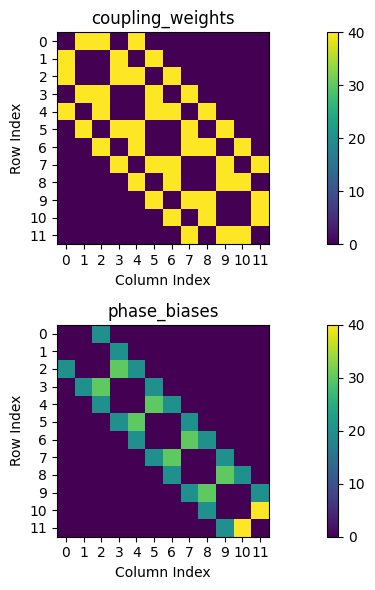

In [6]:
# Show CPG parameters
coupling_weights = info['coupling_weights']
phase_biases= info['phase_biases']



fig, axs = plt.subplots(2,1, figsize=(12, 6))  # Adjust size if needed

im1 = axs[0].imshow(coupling_weights, cmap='viridis', aspect='equal')
fig.colorbar(im1, ax=axs[0], orientation='vertical')  # Add a color bar for reference
axs[0].set_title("coupling_weights")
axs[0].set_xlabel("Column Index")
axs[0].set_ylabel("Row Index")
axs[0].set_xticks(range(12))
axs[0].set_yticks(range(12))

im2 = axs[1].imshow(phase_biases, cmap='viridis', aspect='equal')
fig.colorbar(im1, ax=axs[1], orientation='vertical')  # Add a color bar for reference
axs[1].set_title("phase_biases")
axs[1].set_xlabel("Column Index")
axs[1].set_ylabel("Row Index")
axs[1].set_xticks(range(12))
axs[1].set_yticks(range(12))


plt.tight_layout()
plt.show()